In [1]:
import keras
import numpy as np
import pandas as pd
import plotly.express as px
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import  accuracy_score, f1_score


In [2]:

def evaluate_model(y_test, y_pred, classifier_name, color_sequence):


    conf_matrix = confusion_matrix(y_test, y_pred)

    conf_mat_fig = px.imshow(conf_matrix,
                        x = ["Non-Click  ","Click  "],
                        y = ["Non-Click  ","Click  "],
                        color_continuous_scale=color_sequence
                    )


    conf_mat_fig.update_layout(title_text='<b>Confusion Matrix' +" " +classifier_name+"<b>", )

    conf_mat_fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))


    conf_mat_fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.35,
                        y=0.5,
                        showarrow=False,
                        text="Real value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))


    conf_mat_fig.show('png')

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    test_accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    metrics = pd.DataFrame(data=[[test_accuracy]])
    metrics = metrics.T

    colors = ['yellow']
    evaluation_figure =  go.Figure(
                          go.Bar(
                           x = (metrics[0].values),
                           y = ['Testing Accuracy'], text = np.round_(metrics[0].values,4),
                           textposition = 'auto',
                           orientation = 'h', opacity = 0.8,marker=dict(
                           color=colors,
                           line=dict(color='#000000',width=1.5))),

                      )


    evaluation_figure.update_layout(title="<b>Performance Measures"+" "+classifier_name+"</b>")
    evaluation_figure.show('png')


def visualize_curves(y_test, y_score, classifier_name, color_sequence):

    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    prc_curve = px.area(
        x=recall, y=precision,
        title="<b> Precision- Recall Curve" + classifier_name + " (AP=" + str(
            round(average_precision_score(y_test, y_score), 4)) + ")</b>",
        labels=dict(x='Recall', y='Precision'),
        width=700, height=500,
        color_discrete_sequence=color_sequence

    )
    prc_curve.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=1, y1=0
    )

    prc_curve.update_yaxes(scaleanchor="x", scaleratio=1)
    prc_curve.update_xaxes(constrain='domain')
    prc_curve.update_yaxes(title="<b>Precision</b>")
    prc_curve.update_xaxes(title="<b>Recall</b>")

    prc_curve.show("png")

    fpr, tpr, thresholds = roc_curve(y_test, y_score)


    auc_curve = px.area(
        x=fpr, y=tpr,
        title=f'<b>ROC Curve (AUC={auc(fpr, tpr):.4f})' + " " + classifier_name + "</b>",
        labels=dict(x='False Positive Rate', y='True Positive Rate'),
        width=700, height=500,
        color_discrete_sequence=color_sequence

    )
    auc_curve.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    gmeans = np.sqrt(tpr * (1 - fpr))
    index = np.argmax(gmeans)

    auc_curve.add_annotation(xref="x domain", yref="y",
                             x=fpr[index],
                             y=tpr[index],
                             text="Best Thresholds point Proba:" + str(round(thresholds[index], 3)),
                             axref="x domain", ayref="y", arrowhead=2,
                             )

    auc_curve.update_yaxes(scaleanchor="x", scaleratio=1)
    auc_curve.update_xaxes(constrain='domain')
    auc_curve.update_xaxes(title="<b>False Positive Rate</b>")
    auc_curve.update_yaxes(title="<b>True Positive Rate</b>")

    auc_curve.show('png')

    pos = pd.get_dummies(y_test).to_numpy()

    pos = pos[:, 1]
    npos = np.sum(pos)

    index = np.argsort(y_score)
    index = index[::-1]
    sort_pos = pos[index]
    cpos = np.cumsum(sort_pos)
    recall = cpos / npos
    n = y_test.shape[0]
    size = np.arange(start=1, stop=n, step=1)
    size = size / n

    recall = np.delete(recall, -1)

    index = np.argmax(recall - size)

    cum_gain = px.area(x=size, y=recall,
                       color_discrete_sequence=color_sequence
                       )

    cum_gain.add_annotation(xref="x domain", yref="y",
                            x=size[index],
                            y=recall[index],
                            text="Best Decision point, Gain:(" + str(
                                round(recall[index], 2)) + ") and Population:(" + str(round(size[index], 2)) + ")",
                            axref="x domain", ayref="y", arrowhead=2,
                            )
    cum_gain.update_yaxes(title="<b>Gain</b>")
    cum_gain.update_xaxes(title="<b> % of Population</b>")
    cum_gain.update_layout(title="<b>Cumulative Gain " + " " + classifier_name + "</b>")

    cum_gain.show('png')

In [3]:

data = pd.read_csv("final_balanced_data.csv")
labels = data["like"]

del data['like']

# numpify..
data = data.to_numpy()
labels = labels.to_numpy()

optimizer = keras.optimizers.Adam(lr=0.001)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1)

In [4]:

my_init = keras.initializers.glorot_uniform(seed=1)
# lets make the network run first:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=17, kernel_initializer=my_init))
# model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid', kernel_initializer=my_init))
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=10000, epochs=150, verbose=2, validation_split=0.33)

print(model.summary())



Epoch 1/150
828/828 - 3s - loss: 127292.6250 - accuracy: 0.5151 - val_loss: 11138.6934 - val_accuracy: 0.5229
Epoch 2/150
828/828 - 2s - loss: 10842.6797 - accuracy: 0.5307 - val_loss: 5214.8281 - val_accuracy: 0.5292
Epoch 3/150
828/828 - 2s - loss: 7185.3433 - accuracy: 0.5348 - val_loss: 7875.7480 - val_accuracy: 0.4988
Epoch 4/150
828/828 - 1s - loss: 7126.8579 - accuracy: 0.5275 - val_loss: 2525.4324 - val_accuracy: 0.5895
Epoch 5/150
828/828 - 1s - loss: 7320.5908 - accuracy: 0.5254 - val_loss: 15288.1826 - val_accuracy: 0.5005
Epoch 6/150
828/828 - 1s - loss: 6916.0742 - accuracy: 0.5255 - val_loss: 2393.4292 - val_accuracy: 0.5546
Epoch 7/150
828/828 - 1s - loss: 6533.4297 - accuracy: 0.5266 - val_loss: 3597.4941 - val_accuracy: 0.5708
Epoch 8/150
828/828 - 1s - loss: 6940.9370 - accuracy: 0.5271 - val_loss: 14686.5508 - val_accuracy: 0.4847
Epoch 9/150
828/828 - 1s - loss: 6391.9272 - accuracy: 0.5278 - val_loss: 5896.8472 - val_accuracy: 0.5300
Epoch 10/150
828/828 - 1s - los

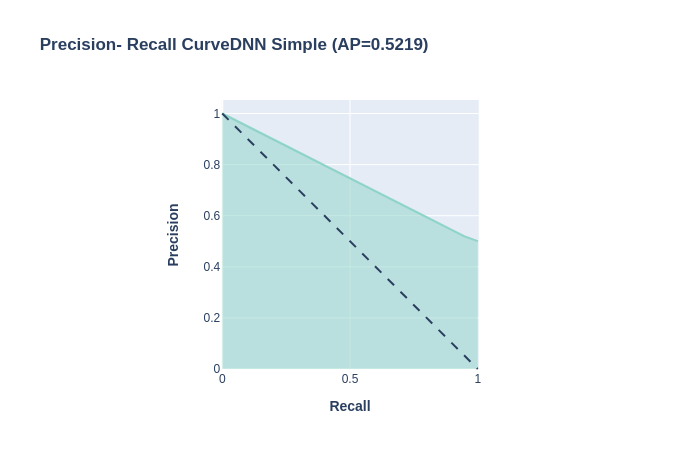

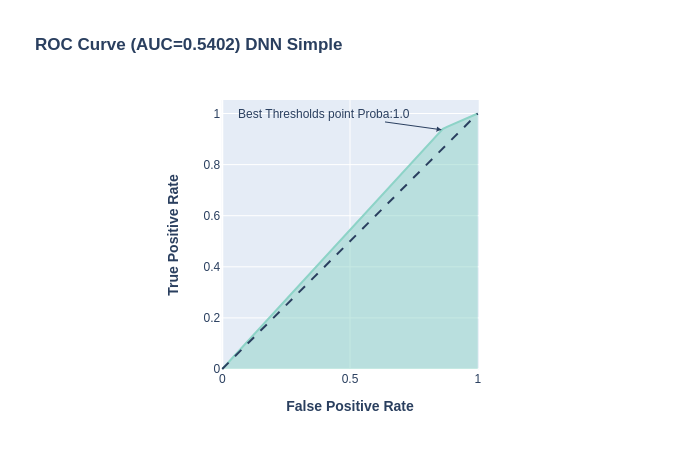

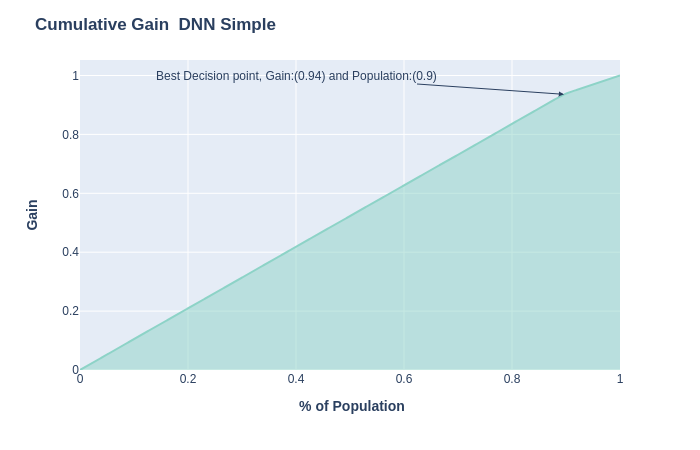

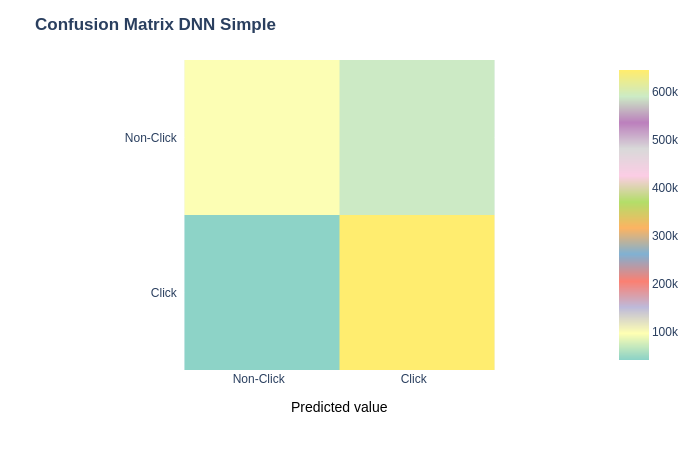

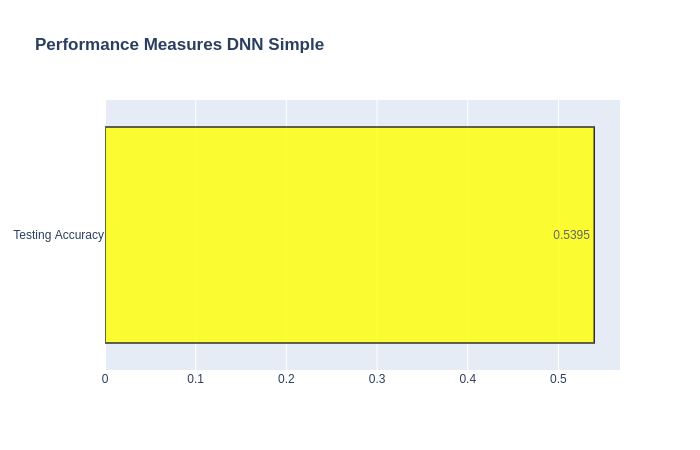

In [5]:



predictions = model.predict(X_test)

y_pred = [1 if y > 0.5 else 0 for y in predictions]

y_score = model.predict(X_test)
y_score = [score[0] for score in y_score]

y_train_pred = model.predict(X_train)

y_train_pred = [1 if y > 0.5 else 0 for y in y_train_pred]


visualize_curves(y_test, y_score, "DNN Simple", px.colors.qualitative.Set3)
evaluate_model(y_test, y_pred, "DNN Simple", px.colors.qualitative.Set3)
